### Import Libraries

In [1]:
import math
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path
import re
from skimage.metrics  import structural_similarity as ssim
import plotly.io as pio
import plotly.express as px
import pandas as pd
import pickle
import cv2
import plotly.io as pio
import plotly.express as px
import itertools

pio.renderers.default = 'iframe'

### Define Paths

In [2]:
research_dir = r"D:/school/research"
code_dir = os.path.join(research_dir, "code")
p2_dir = os.path.join(code_dir, "paper_two_code")
model_dir = os.path.join(p2_dir, "models")
metrics_dir = os.path.join(p2_dir, "metrics")
seg_metrics_dir = os.path.join(metrics_dir, "seg_to_seg")

### Helpers

In [3]:
segment_info = [
    "Cerebrospinal Fluid",
    "Cortical Grey Matter",
    "White Matter",
    "Background",
    "Ventricle",
    "Cerebelum",
    "Deep Grey Matter",
    "Brainstem",
    "Hippocampus"
]

std_bands = [
    {
        "range": "-inf to -4",
        "low": -np.inf,
        "high": -4
    },
    {
        "range": "-4 to -3",
        "low": -4,
        "high": -3
    },
    {
        "range": "-3 to -2",
        "low": -3,
        "high": -2
    },
    {
        "range": "2 to 3",
        "low": 2,
        "high": 3
    },
    {
        "range": "3 to 4",
        "low": 3,
        "high": 4
    },
    {
        "range": "4 to inf",
        "low": 4,
        "high": np.inf
    }
]


### Get All Metrics

In [18]:
model_name

'T2 OPS'

In [20]:
segments = []
model = []
runs = []
all_losses = []
all_clusters = []


models = {
    
    "T1 AIO": "seg9_to_seg9",
    "T1 OPS": "overall_single_seg_t1",
    "T2 AIO": "seg9_to_seg9",
    "T2 OPS": "overall_single_seg_t2",
}

for model_name in models.keys():
    for run in ["train", "val", "test"]:
        prefix = f"{models[model_name]}_{run}"
        losses = np.load(os.path.join(seg_metrics_dir, f"{prefix}_losses.npy"), allow_pickle=True)
        # segment_losses = np.load(os.path.join(seg_metrics_dir, f"{prefix}_segment_losses.npy"), allow_pickle=True).item()
        clusters= np.load(os.path.join(seg_metrics_dir, f"{prefix}_clusters.npy"), allow_pickle=True)
        # segment_clusters = np.load(os.path.join(seg_metrics_dir, f"{prefix}_segment_clusters.npy"), allow_pickle=True).item()

        # Overall losses
        model.extend([model_name for x in range(0, len(losses))])
        runs.extend([run.capitalize() for x in range(0, len(losses))])
        all_losses.extend(losses)
        all_clusters.extend(clusters)


loss_df = pd.DataFrame({"Model": model, "Runs": runs, "Losses": all_losses, "Clusters": all_clusters})

In [26]:
fig = px.box(
    loss_df,
    x="Model",
    y="Losses",
    color="Runs",
    color_discrete_map={
        "Train": "green",
        "Val": "orange",
        "Test": "red"
    }
)
fig.update_traces(quartilemethod="exclusive")
fig.update_layout(
    xaxis_title="Model Version",
    yaxis_title="Loss (MSE)",
    legend_title="Run Name",
    font=dict(
        family="Arial",
        size=28
    )
)
# fig.update_yaxes(range=[0, 0.005])
fig.show()
fig.write_image("figures/segmented_losses.png", width=2000, height=700)

In [28]:
fig = px.box(
    loss_df,
    x="Model",
    y="Clusters",
    color="Runs",
    color_discrete_map={
        "Train": "green",
        "Val": "orange",
        "Test": "red"
    }
)
fig.update_traces(quartilemethod="exclusive")
fig.update_layout(
    xaxis_title="Model Version",
    yaxis_title="Cluster Size (Pixels)",
    legend_title="Run Name",
    font=dict(
        family="Arial",
        size=28
    )
)
# fig.update_yaxes(range=[0, 0.005])
fig.show()
fig.write_image("figures/segmented_clusters.png", width=2000, height=700)

### Get T2 9 to 9 Metrics

In [12]:
segments = []
runs = []
all_losses = []
all_clusters = []

total_pixels = 256**3
pixels = []
pixel_runs = []
pixel_band = []
pixel_segment = []

cluster_runs = []
cluster_models = []
cluster_band = []

for run in ["train", "val", "test"]:
    prefix = f"seg9_to_seg9_{run}"
    losses = np.load(os.path.join(seg_metrics_dir, f"{prefix}_losses.npy"), allow_pickle=True)
    segment_losses = np.load(os.path.join(seg_metrics_dir, f"{prefix}_segment_losses.npy"), allow_pickle=True).item()
    clusters= np.load(os.path.join(seg_metrics_dir, f"{prefix}_clusters.npy"), allow_pickle=True)
    segment_clusters = np.load(os.path.join(seg_metrics_dir, f"{prefix}_segment_clusters.npy"), allow_pickle=True).item()
    
    # Overall losses
    segments.extend(["Overall" for x in range(0, len(losses))])
    runs.extend([run.capitalize() for x in range(0, len(losses))])
    all_losses.extend(losses)
    all_clusters.extend(clusters)
    
#     # Segment losses
#     for segment in segment_losses.keys():
#         sl = segment_losses[segment]
#         sc = segment_clusters[segment]
#         segments.extend([segment for x in range(0, len(sl))])
#         runs.extend([run.capitalize() for x in range(0, len(sl))])
#         all_losses.extend(sl)
#         all_clusters.extend(sc)
    
    
#     with open(os.path.join(seg_metrics_dir, f"{prefix}_banded_metrics.pkl"), "rb") as f:
#         bands = pickle.load(f)
#     with open(os.path.join(seg_metrics_dir, f"{prefix}_banded_segment_metrics.pkl"), "rb") as f:
#         segment_bands = pickle.load(f)
    
    
#     # Get pixel percents
#     for band in [x["range"] for x in std_bands]:
#         pix = np.mean([(x / total_pixels) * 100 for x in bands[f"{band} pixels"]])
#         pixels.append(pix)
#         pixel_runs.append(run.capitalize())
#         pixel_band.append(band)
#         pixel_segment.append("Overall")
        
#         clust = np.mean([np.mean(x) for x in bands[f"{band} clusters"]])
#         cluster_band.append(clust)
        
#         for segment in segment_info:
#             pix = np.mean([(x / total_pixels) * 100 for x in segment_bands[f"{band} pixels"][segment]])
#             pixels.append(pix)
#             pixel_runs.append(run.capitalize())
#             pixel_band.append(band)
#             pixel_segment.append(segment)
            
#             clust = np.mean([np.mean(x) for x in segment_bands[f"{band} clusters"][segment]])
#             cluster_band.append(clust)
            # seg_band_pixels = 
        
    # # Get average clusters
    # for band in [x["range"] for x in std_bands]:
    #     clust = np.mean([np.mean(x) for x in bands[f"{band} clusters"]])
    #     clusters.append(clust)

# loss_df = pd.DataFrame({"Runs": runs, "Segments": segments, "Losses": all_losses, "Clusters": all_clusters})

banded_df = pd.DataFrame({"Runs": pixel_runs, "Segment": pixel_segment, "Band": pixel_band, "Pixels Percentage": pixels, "Clusters": cluster_band})

t2_9to9_df = loss_df.copy()

In [51]:
fig = px.box(
    loss_df,
    x="Segments",
    y="Losses",
    color="Runs",
    color_discrete_map={
        "Train": "green",
        "Val": "orange",
        "Test": "red"
    }
)
fig.update_traces(quartilemethod="exclusive")
fig.update_layout(
    xaxis_title="Model Version",
    yaxis_title="Loss (MSE)",
    legend_title="Run Name",
    font=dict(
        family="Arial",
        size=28
    )
)
fig.update_yaxes(range=[0, 0.02])
fig.show()
fig.write_image("figures/segmented_losses_t2_9to9.png", width=2000, height=700)

In [52]:
fig = px.box(
    loss_df,
    x="Segments",
    y="Clusters",
    color="Runs",
    color_discrete_map={
        "Train": "green",
        "Val": "orange",
        "Test": "red"
    }
)
fig.update_traces(quartilemethod="exclusive") 
fig.update_layout(
    yaxis_title="Cluster Size (Pixels)",
    legend_title="Run Name",
    font=dict(
        family="Arial",
        size=28
    )
)
fig.update_yaxes(range=[0, 1200])
fig.show()
fig.write_image("figures/segmented_clusters_t2_9to9.png", width=2000, height=700)

In [53]:
fig = px.bar(
    banded_df,
    x="Runs",
    y="Pixels Percentage",
    color="Band",
    facet_col="Segment",
    color_discrete_map={
        "-inf to -4": "#003d9e",
        "-4 to -3": "#3272d9",
        "-3 to -2": "#80acf2",
        "2 to 3": "#f28080",
        "3 to 4": "#d14343",
        "4 to inf": "#a10606"
    }
)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.for_each_xaxis(lambda x: x.update(title = ''))
fig.update_layout(
    font=dict(
        family="Arial",
        size=18
    )
)
fig.update_yaxes(range=[0, 7])
fig.show()
fig.write_image("figures/segmented_banded_pixels_t2_9to9.png", width=2000, height=500)

In [54]:
fig = px.bar(
    banded_df,
    x="Runs",
    y="Clusters",
    color="Band",
    facet_col="Segment",
    color_discrete_map={
        "-inf to -4": "#003d9e",
        "-4 to -3": "#3272d9",
        "-3 to -2": "#80acf2",
        "2 to 3": "#f28080",
        "3 to 4": "#d14343",
        "4 to inf": "#a10606"
    }
)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.for_each_xaxis(lambda x: x.update(title = ''))
fig.update_layout(
    font=dict(
        family="Arial",
        size=18
    )
)
fig.update_yaxes(range=[0, 175])
fig.show()
fig.write_image("figures/segmented_banded_clusters_t2_9to9.png", width=2000, height=500)

### Get T1 9 to 9 Metrics

In [55]:
segments = []
runs = []
all_losses = []
all_clusters = []

total_pixels = 256**3
pixels = []
pixel_runs = []
pixel_band = []
pixel_segment = []

cluster_runs = []
cluster_models = []
cluster_band = []

for run in ["train", "val", "test"]:
    prefix = f"seg9_to_seg9_t1_{run}"
    losses = np.load(os.path.join(seg_metrics_dir, f"{prefix}_losses.npy"), allow_pickle=True)
    segment_losses = np.load(os.path.join(seg_metrics_dir, f"{prefix}_segment_losses.npy"), allow_pickle=True).item()
    clusters= np.load(os.path.join(seg_metrics_dir, f"{prefix}_clusters.npy"), allow_pickle=True)
    segment_clusters = np.load(os.path.join(seg_metrics_dir, f"{prefix}_segment_clusters.npy"), allow_pickle=True).item()
    
    # Overall losses
    segments.extend(["Overall" for x in range(0, len(losses))])
    runs.extend([run.capitalize() for x in range(0, len(losses))])
    all_losses.extend(losses)
    all_clusters.extend(clusters)
    
    # Segment losses
    for segment in segment_losses.keys():
        sl = segment_losses[segment]
        sc = segment_clusters[segment]
        segments.extend([segment for x in range(0, len(sl))])
        runs.extend([run.capitalize() for x in range(0, len(sl))])
        all_losses.extend(sl)
        all_clusters.extend(sc)
    
    
    with open(os.path.join(seg_metrics_dir, f"{prefix}_banded_metrics.pkl"), "rb") as f:
        bands = pickle.load(f)
    with open(os.path.join(seg_metrics_dir, f"{prefix}_banded_segment_metrics.pkl"), "rb") as f:
        segment_bands = pickle.load(f)
    
    
    # Get pixel percents
    for band in [x["range"] for x in std_bands]:
        pix = np.mean([(x / total_pixels) * 100 for x in bands[f"{band} pixels"]])
        pixels.append(pix)
        pixel_runs.append(run.capitalize())
        pixel_band.append(band)
        pixel_segment.append("Overall")
        
        clust = np.mean([np.mean(x) for x in bands[f"{band} clusters"]])
        cluster_band.append(clust)
        
        for segment in segment_info:
            pix = np.mean([(x / total_pixels) * 100 for x in segment_bands[f"{band} pixels"][segment]])
            pixels.append(pix)
            pixel_runs.append(run.capitalize())
            pixel_band.append(band)
            pixel_segment.append(segment)
            
            clust = np.mean([np.mean(x) for x in segment_bands[f"{band} clusters"][segment]])
            cluster_band.append(clust)
            # seg_band_pixels = 
        
    # # Get average clusters
    # for band in [x["range"] for x in std_bands]:
    #     clust = np.mean([np.mean(x) for x in bands[f"{band} clusters"]])
    #     clusters.append(clust)

loss_df = pd.DataFrame({"Runs": runs, "Segments": segments, "Losses": all_losses, "Clusters": all_clusters})

banded_df = pd.DataFrame({"Runs": pixel_runs, "Segment": pixel_segment, "Band": pixel_band, "Pixels Percentage": pixels, "Clusters": cluster_band})

t1_9to9_df = loss_df.copy()

In [56]:
fig = px.box(
    loss_df,
    x="Segments",
    y="Losses",
    color="Runs",
    color_discrete_map={
        "Train": "green",
        "Val": "orange",
        "Test": "red"
    }
)
fig.update_traces(quartilemethod="exclusive")
fig.update_layout(
    xaxis_title="Model Version",
    yaxis_title="Loss (MSE)",
    legend_title="Run Name",
    font=dict(
        family="Arial",
        size=28
    )
)
fig.update_yaxes(range=[0, 0.02])
fig.show()
fig.write_image("figures/segmented_losses_t1_9to9.png", width=2000, height=700)

In [57]:
fig = px.box(
    loss_df,
    x="Segments",
    y="Clusters",
    color="Runs",
    color_discrete_map={
        "Train": "green",
        "Val": "orange",
        "Test": "red"
    }
)
fig.update_traces(quartilemethod="exclusive")
fig.update_layout(
    xaxis_title="Model Version",
    yaxis_title="Cluster Size (Pixels)",
    legend_title="Run Name",
    font=dict(
        family="Arial",
        size=28
    )
)
fig.update_yaxes(range=[0, 1200])
fig.show()
fig.write_image("figures/segmented_clusters_t1_9to9.png", width=2000, height=700)

In [58]:
fig = px.bar(
    banded_df,
    x="Runs",
    y="Pixels Percentage",
    color="Band",
    facet_col="Segment",
    color_discrete_map={
        "-inf to -4": "#003d9e",
        "-4 to -3": "#3272d9",
        "-3 to -2": "#80acf2",
        "2 to 3": "#f28080",
        "3 to 4": "#d14343",
        "4 to inf": "#a10606"
    }
)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.for_each_xaxis(lambda x: x.update(title = ''))
fig.update_layout(
    font=dict(
        family="Arial",
        size=18
    )
)
fig.update_yaxes(range=[0, 7])
fig.show()
fig.write_image("figures/segmented_banded_pixels_t1_9to9.png", width=2000, height=500)

In [59]:
fig = px.bar(
    banded_df,
    x="Runs",
    y="Clusters",
    color="Band",
    facet_col="Segment",
    color_discrete_map={
        "-inf to -4": "#003d9e",
        "-4 to -3": "#3272d9",
        "-3 to -2": "#80acf2",
        "2 to 3": "#f28080",
        "3 to 4": "#d14343",
        "4 to inf": "#a10606"
    }
)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.for_each_xaxis(lambda x: x.update(title = ''))
fig.update_layout(
    font=dict(
        family="Arial",
        size=18
    )
)
fig.update_yaxes(range=[0, 175])
fig.show()
fig.write_image("figures/segmented_banded_clusters_t1_9to9.png", width=2000, height=500)

### Get T2 1 to 1 Metrics

In [60]:
seg1_runs = []
seg1_segments = []
seg1_losses = []
seg1_clusters = []

total_pixels = 256**3
pixels = []
pixel_runs = []
pixel_band = []
pixel_segment = []

cluster_runs = []
cluster_models = []
cluster_band = []


for run in ["train", "val", "test"]:
    # overall metrics
    prefix = f"overall_single_seg_t2_{run}"
    overall_losses = np.load(os.path.join(seg_metrics_dir, f"{prefix}_losses.npy"))
    overall_clusters = np.load(os.path.join(seg_metrics_dir, f"{prefix}_clusters.npy"))
    with open(os.path.join(seg_metrics_dir, f"{prefix}_banded_metrics.pkl"), "rb") as f:
        overall_bands = pickle.load(f)

    seg1_runs.extend([run.capitalize() for x in range(0, len(overall_losses))])
    seg1_segments.extend(["Overall" for x in range(0, len(overall_losses))])
    seg1_losses.extend(overall_losses)
    seg1_clusters.extend(overall_clusters)

    # Get pixel percents
    for band in [x["range"] for x in std_bands]:
        pix = np.mean([(x / total_pixels) * 100 for x in np.nan_to_num(overall_bands[f"{band} pixels"])])
        pixels.append(pix)
        pixel_runs.append(run.capitalize())
        pixel_band.append(band)
        pixel_segment.append("Overall")

        clust = np.mean([np.mean(x) for x in np.nan_to_num(overall_bands[f"{band} clusters"])])
        cluster_band.append(clust)

for idx, segment in enumerate(segment_info):
    for run in ["train", "val", "test"]:
        # segmented metrics
        prefix = f"seg{idx}_{run}"
        seg_losses = np.load(os.path.join(seg_metrics_dir, f"{prefix}_losses.npy"))
        seg_clusters = np.load(os.path.join(seg_metrics_dir, f"{prefix}_clusters.npy"))
        with open(os.path.join(seg_metrics_dir, f"{prefix}_banded_metrics.pkl"), "rb") as f:
            seg_bands = pickle.load(f)
        
        seg1_runs.extend([run.capitalize() for x in range(0, len(seg_losses))])
        seg1_segments.extend([segment for x in range(0, len(seg_losses))])
        seg1_losses.extend(seg_losses)
        seg1_clusters.extend(seg_clusters)
        
        # Get pixel percents
        for band in [x["range"] for x in std_bands]:
            pix = np.mean([(x / total_pixels) * 100 for x in np.nan_to_num(seg_bands[f"{band} pixels"])])
            pixels.append(pix)
            pixel_runs.append(run.capitalize())
            pixel_band.append(band)
            pixel_segment.append(segment)

            clust = np.mean([np.mean(x) for x in np.nan_to_num(seg_bands[f"{band} clusters"])])
            cluster_band.append(clust)
    
seg1_df = pd.DataFrame({"Runs": seg1_runs, "Segment": seg1_segments, "Losses": seg1_losses, "Clusters": seg1_clusters})

seg1_banded_df = pd.DataFrame({"Runs": pixel_runs, "Segment": pixel_segment, "Band": pixel_band, "Pixels Percentage": pixels, "Clusters": cluster_band})

t2_1to1_df = seg1_df.copy()

In [61]:
fig = px.box(
    seg1_df,
    x="Segment",
    y="Losses",
    color="Runs",
    color_discrete_map={
        "Train": "green",
        "Val": "orange",
        "Test": "red"
    }
)
fig.update_traces(quartilemethod="exclusive")
fig.update_layout(
    xaxis_title="Model Version",
    yaxis_title="Loss (MSE)",
    legend_title="Run Name",
    font=dict(
        family="Arial",
        size=28
    )
)
fig.update_yaxes(range=[0, 0.02])
fig.show()
fig.write_image("figures/segmented_losses_t2_1to1.png", width=2000, height=700)

In [62]:
fig = px.box(
    seg1_df,
    x="Segment",
    y="Clusters",
    color="Runs",
    color_discrete_map={
        "Train": "green",
        "Val": "orange",
        "Test": "red"
    }
)
fig.update_traces(quartilemethod="exclusive")
fig.update_layout(
    xaxis_title="Model Version",
    yaxis_title="Cluster Size (Pixels)",
    legend_title="Run Name",
    font=dict(
        family="Arial",
        size=28
    )
)
fig.update_yaxes(range=[0, 1200])
fig.show()
fig.write_image("figures/segmented_clusters_t2_1to1.png", width=2000, height=700)

In [63]:
fig = px.bar(
    seg1_banded_df,
    x="Runs",
    y="Pixels Percentage",
    color="Band",
    facet_col="Segment",
    color_discrete_map={
        "-inf to -4": "#003d9e",
        "-4 to -3": "#3272d9",
        "-3 to -2": "#80acf2",
        "2 to 3": "#f28080",
        "3 to 4": "#d14343",
        "4 to inf": "#a10606"
    }
)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.for_each_xaxis(lambda x: x.update(title = ''))
fig.update_layout(
    font=dict(
        family="Arial",
        size=18
    )
)
fig.update_yaxes(range=[0, 7])
fig.show()
fig.write_image("figures/segmented_banded_pixels_t2_1to1.png", width=2000, height=500)

In [64]:
fig = px.bar(
    seg1_banded_df,
    x="Runs",
    y="Clusters",
    color="Band",
    facet_col="Segment",
    color_discrete_map={
        "-inf to -4": "#003d9e",
        "-4 to -3": "#3272d9",
        "-3 to -2": "#80acf2",
        "2 to 3": "#f28080",
        "3 to 4": "#d14343",
        "4 to inf": "#a10606"
    }
)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.for_each_xaxis(lambda x: x.update(title = ''))
fig.update_layout(
    font=dict(
        family="Arial",
        size=18
    )
)
fig.update_yaxes(range=[0, 175])
fig.show()
fig.write_image("figures/segmented_banded_clusters_t2_1to1.png", width=2000, height=500)

### Get T1 1 to 1 Metrics

In [65]:
seg1_runs = []
seg1_segments = []
seg1_losses = []
seg1_clusters = []

total_pixels = 256**3
pixels = []
pixel_runs = []
pixel_band = []
pixel_segment = []

cluster_runs = []
cluster_models = []
cluster_band = []


for run in ["train", "val", "test"]:
    # overall metrics
    prefix = f"overall_single_seg_t1_{run}"
    overall_losses = np.load(os.path.join(seg_metrics_dir, f"{prefix}_losses.npy"))
    overall_clusters = np.load(os.path.join(seg_metrics_dir, f"{prefix}_clusters.npy"))
    with open(os.path.join(seg_metrics_dir, f"{prefix}_banded_metrics.pkl"), "rb") as f:
        overall_bands = pickle.load(f)

    seg1_runs.extend([run.capitalize() for x in range(0, len(overall_losses))])
    seg1_segments.extend(["Overall" for x in range(0, len(overall_losses))])
    seg1_losses.extend(overall_losses)
    seg1_clusters.extend(overall_clusters)

    # Get pixel percents
    for band in [x["range"] for x in std_bands]:
        pix = np.mean([(x / total_pixels) * 100 for x in np.nan_to_num(overall_bands[f"{band} pixels"])])
        pixels.append(pix)
        pixel_runs.append(run.capitalize())
        pixel_band.append(band)
        pixel_segment.append("Overall")

        clust = np.mean([np.mean(x) for x in np.nan_to_num(overall_bands[f"{band} clusters"])])
        cluster_band.append(clust)

for idx, segment in enumerate(segment_info):
    for run in ["train", "val", "test"]:
        # segmented metrics
        prefix = f"seg{idx}_t1_{run}"
        seg_losses = np.load(os.path.join(seg_metrics_dir, f"{prefix}_losses.npy"))
        seg_clusters = np.load(os.path.join(seg_metrics_dir, f"{prefix}_clusters.npy"))
        with open(os.path.join(seg_metrics_dir, f"{prefix}_banded_metrics.pkl"), "rb") as f:
            seg_bands = pickle.load(f)
        
        seg1_runs.extend([run.capitalize() for x in range(0, len(seg_losses))])
        seg1_segments.extend([segment for x in range(0, len(seg_losses))])
        seg1_losses.extend(seg_losses)
        seg1_clusters.extend(seg_clusters)
        
        # Get pixel percents
        for band in [x["range"] for x in std_bands]:
            pix = np.mean([(x / total_pixels) * 100 for x in np.nan_to_num(seg_bands[f"{band} pixels"])])
            pixels.append(pix)
            pixel_runs.append(run.capitalize())
            pixel_band.append(band)
            pixel_segment.append(segment)

            clust = np.mean([np.mean(x) for x in np.nan_to_num(seg_bands[f"{band} clusters"])])
            cluster_band.append(clust)
    
seg1_df = pd.DataFrame({"Runs": seg1_runs, "Segment": seg1_segments, "Losses": seg1_losses, "Clusters": seg1_clusters})

seg1_banded_df = pd.DataFrame({"Runs": pixel_runs, "Segment": pixel_segment, "Band": pixel_band, "Pixels Percentage": pixels, "Clusters": cluster_band})

t1_1to1_df = seg1_df.copy()

In [66]:
fig = px.box(
    seg1_df,
    x="Segment",
    y="Losses",
    color="Runs",
    color_discrete_map={
        "Train": "green",
        "Val": "orange",
        "Test": "red"
    }
)
fig.update_traces(quartilemethod="exclusive") 
fig.update_layout(
    xaxis_title="Model Version",
    yaxis_title="Loss (MSE)",
    legend_title="Run Name",
    font=dict(
        family="Arial",
        size=28
    )
)
fig.update_yaxes(range=[0, 0.02])
fig.show()
fig.write_image("figures/segmented_losses_t1_1to1.png", width=2000, height=700)

In [67]:
fig = px.box(
    seg1_df,
    x="Segment",
    y="Clusters",
    color="Runs",
    color_discrete_map={
        "Train": "green",
        "Val": "orange",
        "Test": "red"
    }
)
fig.update_traces(quartilemethod="exclusive") 
fig.update_layout(
    xaxis_title="Model Version",
    yaxis_title="Cluster Size (Pixels)",
    legend_title="Run Name",
    font=dict(
        family="Arial",
        size=28
    )
)
fig.update_yaxes(range=[0, 1200])
fig.show()
fig.write_image("figures/segmented_clusters_t1_1to1.png", width=2000, height=700)

In [68]:
fig = px.bar(
    seg1_banded_df,
    x="Runs",
    y="Pixels Percentage",
    color="Band",
    facet_col="Segment",
    color_discrete_map={
        "-inf to -4": "#003d9e",
        "-4 to -3": "#3272d9",
        "-3 to -2": "#80acf2",
        "2 to 3": "#f28080",
        "3 to 4": "#d14343",
        "4 to inf": "#a10606"
    }
)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.for_each_xaxis(lambda x: x.update(title = ''))
fig.update_layout(
    font=dict(
        family="Arial",
        size=18
    )
)
fig.update_yaxes(range=[0, 7])
fig.show()
fig.write_image("figures/segmented_banded_pixels_t1_1to1.png", width=2000, height=500)

In [69]:
fig = px.bar(
    seg1_banded_df,
    x="Runs",
    y="Clusters",
    color="Band",
    facet_col="Segment",
    color_discrete_map={
        "-inf to -4": "#003d9e",
        "-4 to -3": "#3272d9",
        "-3 to -2": "#80acf2",
        "2 to 3": "#f28080",
        "3 to 4": "#d14343",
        "4 to inf": "#a10606"
    }
)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.for_each_xaxis(lambda x: x.update(title = ''))
fig.update_layout(
    font=dict(
        family="Arial",
        size=18
    )
)
fig.update_yaxes(range=[0, 175])
fig.show()
fig.write_image("figures/segmented_banded_clusters_t1_1to1.png", width=2000, height=500)

### Get ROC Curves

In [74]:
t1_9to9_df["model"] = "T1 All-In-One"
t2_9to9_df["model"] = "T2 All-In-One"
t1_1to1_df["model"] = "T1 One-Per-Segment"
t2_1to1_df["model"] = "T2 One-Per-Segment"

t1_1to1_df.rename(columns = {'Segment':'Segments'}, inplace = True)
t2_1to1_df.rename(columns = {'Segment':'Segments'}, inplace = True)

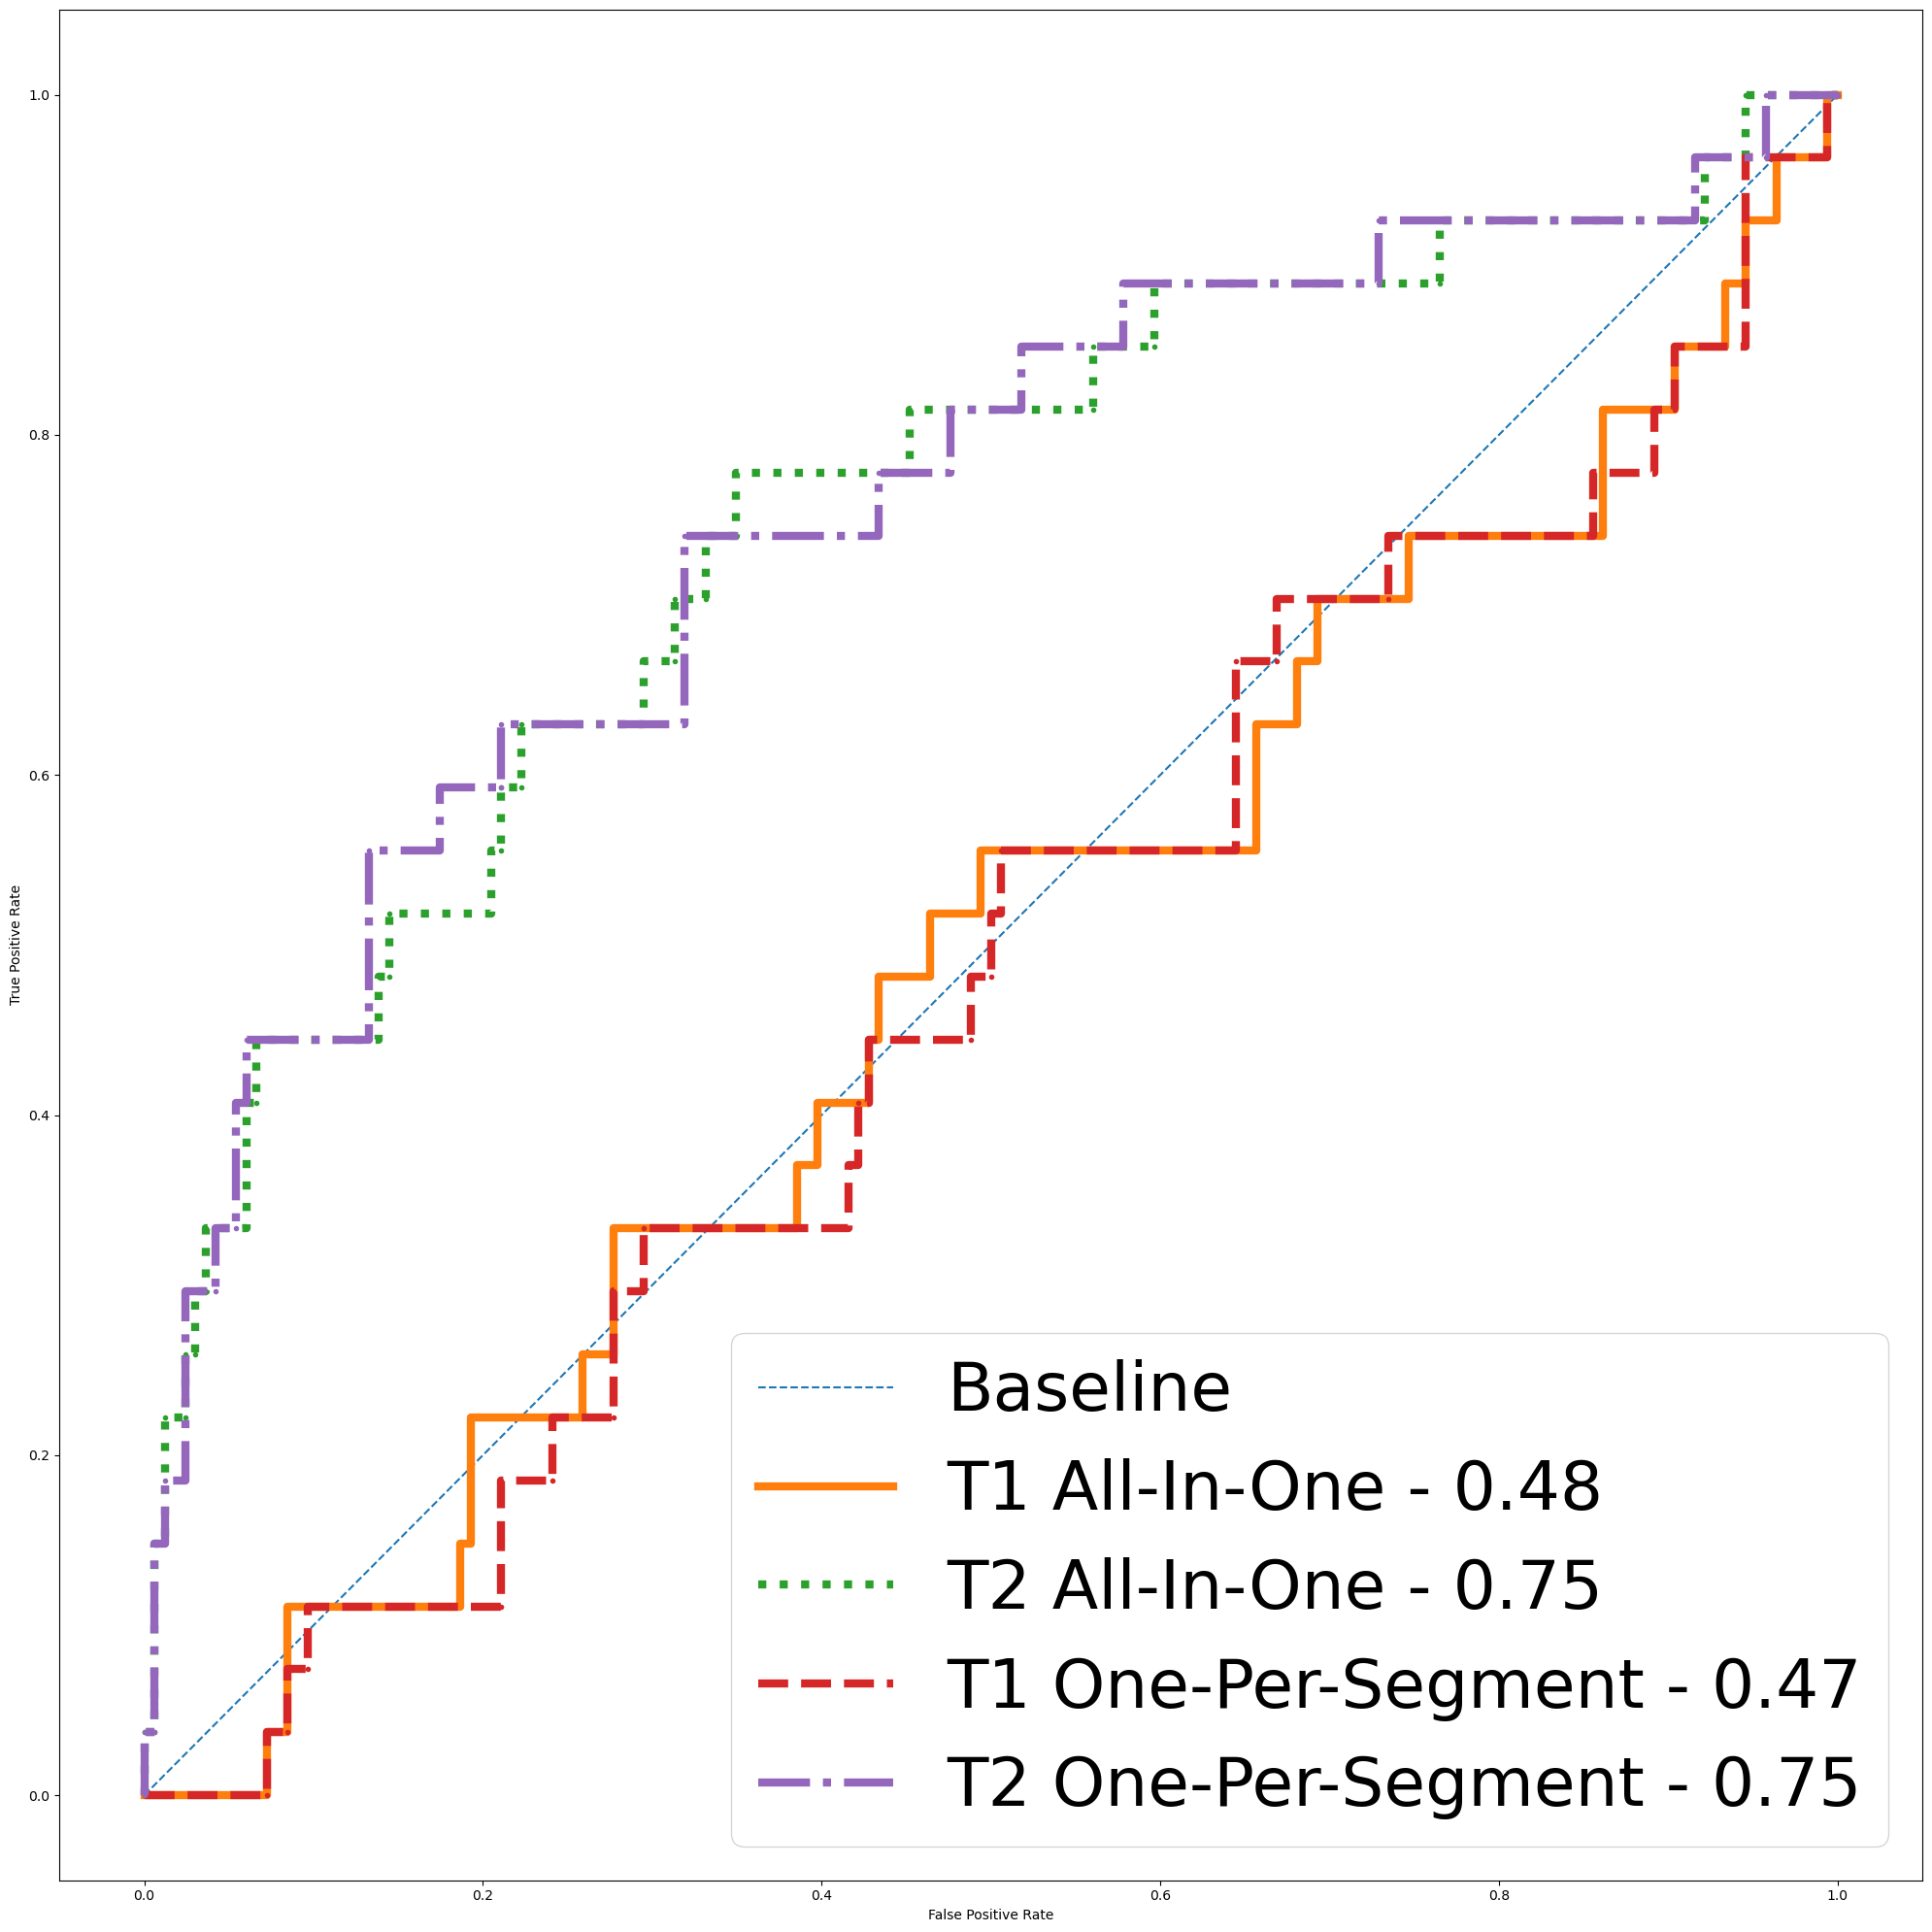

In [87]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score

def get_roc(x, y):
    ns_probs = [0 for _ in range(len(y))]
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y, x)
    auc = roc_auc_score(y, x)
    
    return lr_fpr, lr_tpr, auc

fig, ax = plt.subplots(figsize=(20, 20))

y = [round(np.random.rand()) for x in range(193)]
ns_probs = [0 for _ in range(len(y))]
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline')

line_styles = ['solid', 'dotted', 'dashed', 'dashdot']

# get ROC's for each model
counter = 0
roc_losses = pd.concat([t1_9to9_df, t2_9to9_df, t1_1to1_df, t2_1to1_df], ignore_index=True, axis=0)
for name in ["T1 All-In-One", "T2 All-In-One", "T1 One-Per-Segment", "T2 One-Per-Segment"]:
# for name in ["T1 All-In-One", "T1 One-Per-Segment"]:
    train_loss = roc_losses[(roc_losses["model"] == name) & (roc_losses["Runs"] == "Train") & (roc_losses["Segments"] == "Overall")]["Losses"]
    test_loss = roc_losses[(roc_losses["model"] == name) & (roc_losses["Runs"] == "Test") & (roc_losses["Segments"] == "Overall")]["Losses"]

    x =list(train_loss)
    x.extend(np.array(test_loss))
    x = np.array(x).reshape(-1, 1)
    train_classes = [0] * len(train_loss)
    y = train_classes.copy()
    y.extend([1] * len(test_loss))

    lr_fpr, lr_tpr, auc = get_roc(x,y)
    plt.plot(lr_fpr, lr_tpr, marker='.', label=name + " - {:.2f}".format(auc), linestyle=line_styles[counter], linewidth=6)
    counter += 1

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, prop={'size': 50})

plt.tight_layout()
plt.savefig('figures/segmented_roc.png')